# Trabalho 2: Transfer Learning


Nomes dos integrantes:

1.   Victor Teodoro Goraieb
2.   André de Souza Gonçalves
3.   Vitor Anastacio da Silva

## Importação de pacotes

In [ ]:
# Criação de instância no Google Drive:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Pacotes generalistas
import numpy as np
import pandas as pd

# Importação de pacotes do Sklearn:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

# Visualização de dados e imagens:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes de Deep Learning:
import tensorflow as tf
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

## Definição de funções auxiliares

In [ ]:
def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(15, 15))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

In [ ]:
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        # training
        batch_index = 0
        while batch_index <= training_data.batch_index:
            img, label = training_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x = img_list
        self.y = label_list

        # validation
        batch_index = 0
        while batch_index <= validation_data.batch_index:
            img, label = validation_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x_val = img_list
        self.y_val = label_list


    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        print("SHAPE", y_pred_train.shape)
        roc_train = roc_auc_score(self.y[:,1], y_pred_train[:,1])
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val[:,1], y_pred_val[:,1])
        logs["train_auc"] = roc_val
        logs["val_auc"] = roc_val
        keys = list(logs.keys())
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [ ]:
def plot_loss_evaluation(model_history):
    train_loss = pd.DataFrame({'loss': model_history.history['loss']})
    val_loss =  pd.DataFrame({'val_loss': model_history.history['val_loss']})
    df = pd.concat([train_loss, val_loss], axis = 0)
    sns.set_style('darkgrid')
    sns.lineplot(data = df)
    plt.title('Gráfico de desempenho na função de custo')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure(figsize = (10,10))
    plt.show()


In [ ]:

def plot_confusion_matrix(model, labels, y, x):
    matrix = confusion_matrix(y, np.argmax(model.predict(x), axis=1), normalize = 'true')
    sns.heatmap(matrix, cmap = 'mako', annot = True, fmt = '.2%', xticklabels= labels, yticklabels = labels)
    plt.title('Matriz de Confusão')
    plt.rcParams['figure.figsize'] = (24, 6)
    plt.show()

## Carregamento dos dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val: 150 imagens.
*   isic2017-test: 650 imagens.



In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

In [ ]:
!ls -1 isic2017-train/malignant | wc -l 

374


Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.
Estude o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


## Atividades

1. **(1,0) Aplique aumentação de dados nas imagens, escolhendo três transformações. Mostre exemplos
das transformações escolhidas e justifique porquê elas são válidas neste dataset.**

As três técnicas escolhidas para Data Augmentation foram:

1.   **Rotação:** Decidimos aplicar essa técnica pois entedemos que a depender de como a foto é registrada isso pode impactar a performance do modelo. Assim, aplicando diferentes rotações podemos mitigar esse efeito. Isso é especialmente útil quando avaliamos nódulos pois a rotação permite captar diferentes configurações deste

2.   **Horizontal Flip:** Da mesma forma que a rotação podemos espelhar o nódulo horizontalmente. Isso também oferece uma maior gama de opções para treinamento do modelo.


3.   **Vertical Flip:** Outra forma de espelhamento da imagem é a vertical, que também foi escolhida como forma de data augmentation

Consideramos essas três tranformações, mas também existem outras possibilidades que acreditamos fazer sentido como: zoom, shear e translação. 

Obs: abaixo iniciamos os geradores, e também criamos alguns para conseguir visualizar as imagens (train_for_printing e datagen_for_printing)

In [ ]:
# Datagen
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        rotation_range = 60,
        vertical_flip = True,
        horizontal_flip=True)


# Criação dos geradores
train_generator = train_datagen.flow_from_directory(
        'isic2017-train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed = 42)

validation_generator = train_datagen.flow_from_directory(
        'isic2017-val/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed = 42)

# Datagen e geradores para visualização das imagens
dataaug_datagen_printing = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 60,
        vertical_flip = True,
        horizontal_flip=True)

datagen_for_printing = tf.keras.preprocessing.image.ImageDataGenerator(
)

dataaug_for_printing = dataaug_datagen_printing.flow_from_directory(
        'isic2017-val/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed = 42)

original_images = datagen_for_printing.flow_from_directory(
        'isic2017-val/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed = 42)



Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
# Visualização de algumas transformações

data_aug_visu, _ = dataaug_for_printing.next()
original_visu , _ = original_images.next()

Dados originais ______________________________________________________________________________________


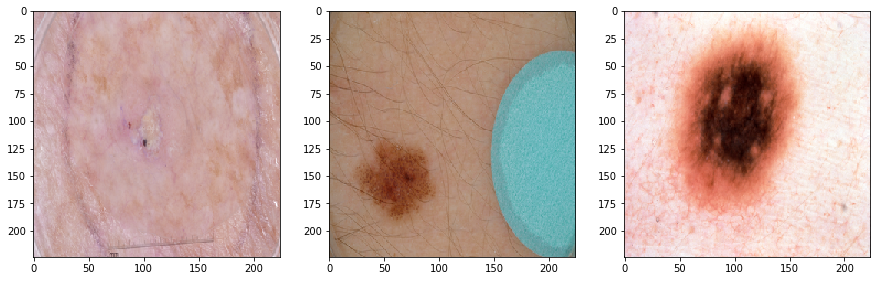

Dados com Data Augmentation __________________________________________________________________________


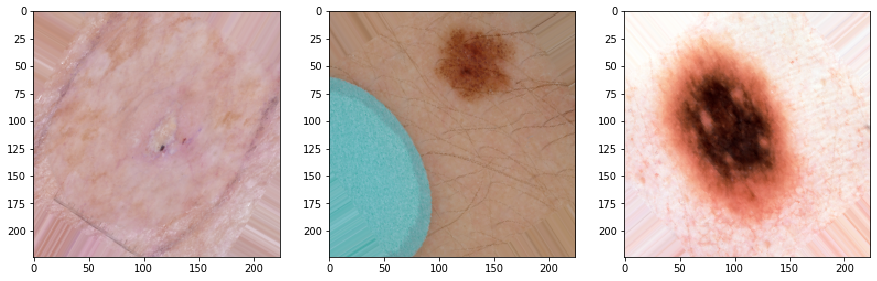

In [ ]:
print('Dados originais ______________________________________________________________________________________')
plotImages(original_visu, 1, 3)

print('Dados com Data Augmentation __________________________________________________________________________')
plotImages(data_aug_visu, 1, 3)



2. **(1,5) Como baseline, construa e treine um modelo convolucional simples. Discuta o resultado.**


In [ ]:
# Podemos ver que o dataset original é consideravelmente desbalanceado: temos uma proporção de ~5x1
pd.Series(train_generator.labels).value_counts()

0    1626
1     374
dtype: int64

In [ ]:
# Para corrigir o desbalanceamento estamos usando um pacote do Sklearn próprio para isso, que irá ajustar o peso na função de custo adequadamente à frequência de cada classe
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.labels),
                                                 train_generator.labels)

In [ ]:
# Definição do tamanho da imagem
input_shape = (224, 224, 3)

# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Criação do ROC
roc = RocCallback(training_data=train_generator,
                  validation_data=validation_generator)

In [ ]:
# Criação do modelo baseline
baseline = Sequential()
baseline.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Flatten())
baseline.add(Dense(64, activation='relu'))
baseline.add(Dense(2, activation='softmax'))

baseline.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

baseline.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 32)      25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 89888)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5752896   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [ ]:
baseline_history = baseline.fit(train_generator, epochs=10,callbacks=[early, roc],
                  validation_data=validation_generator, class_weight=dict(enumerate(class_weights)))

Epoch 1/10
63/63 [==============================] - 65s 545ms/step - loss: 22.5039 - accuracy: 0.4660 - val_loss: 0.6945 - val_accuracy: 0.2133
SHAPE (2000, 2)
roc-auc_train: 0.5009 - roc-auc_val: 0.5282                                                                                                    
Epoch 2/10
63/63 [==============================] - 35s 551ms/step - loss: 0.6931 - accuracy: 0.3735 - val_loss: 0.6928 - val_accuracy: 0.8000
SHAPE (2000, 2)
roc-auc_train: 0.5115 - roc-auc_val: 0.5124                                                                                                    
Epoch 3/10
63/63 [==============================] - 35s 548ms/step - loss: 0.6932 - accuracy: 0.4180 - val_loss: 0.6935 - val_accuracy: 0.7867
SHAPE (2000, 2)
roc-auc_train: 0.5019 - roc-auc_val: 0.4982                                                                                                    
Epoch 4/10
63/63 [==============================] - 35s 551ms/step - loss: 0.6940 - accura

In [ ]:
baseline.save('/content/weights_baseline.h5')
#baseline.load_weights('weights_baseline.h5')

Avaliando o modelo baseline é possível notar que após a primeira época houve uma estagnação das reduções das funções de custo. Além disso, pela matriz de confusão nota-se que o modelo ficou com um recall consideravelmente alto para a classe malignant. Isso é interessante pois se tratando de uma abordagem médica buscamos um recall alto, afinal não podemos dizer que uma pessoa que tenha câncer maligno ter um benigno. O contrário, dizer que uma pessoa que tenha um benigno ter um maligno pode não ser um problema tão grande em termos de triagem. No geral o modelo atende um requisito de recall mas ainda possui espaço para melhorias

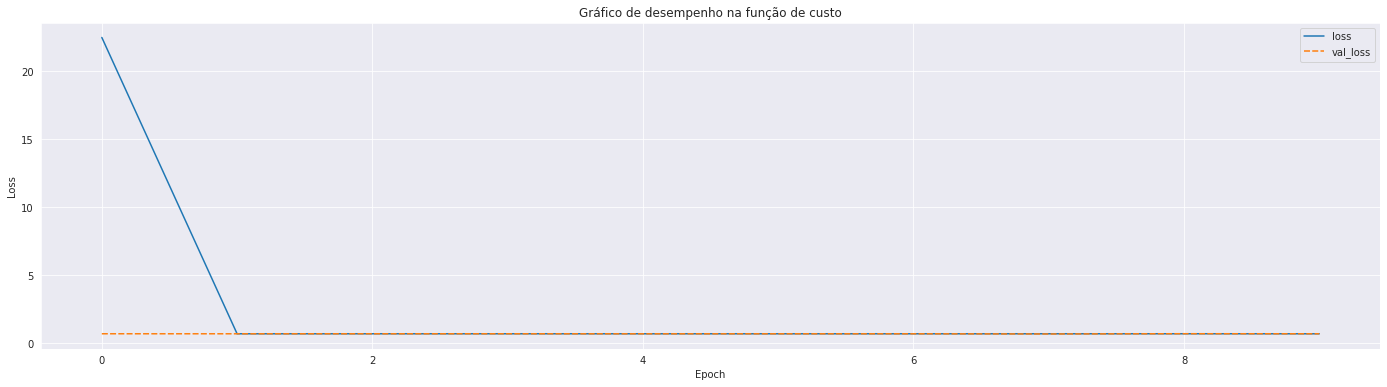

<Figure size 720x720 with 0 Axes>

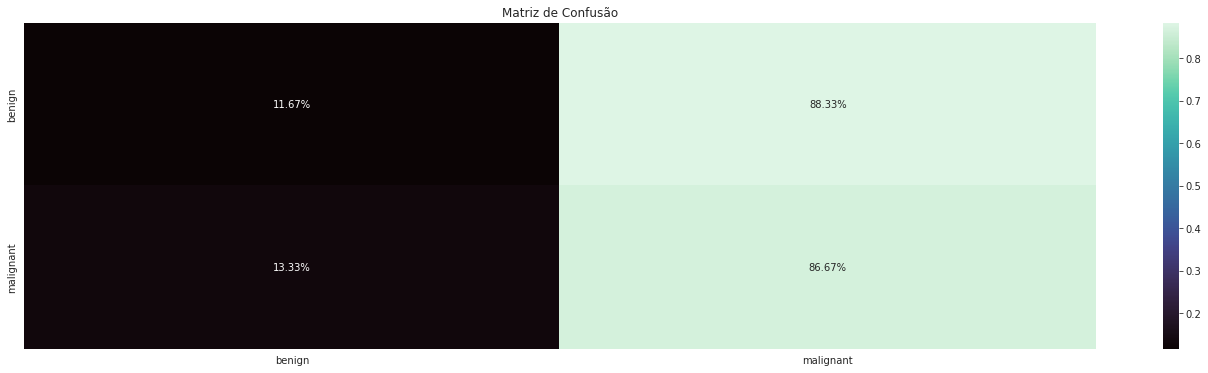

              precision    recall  f1-score   support

      benign       0.73      0.13      0.23       120
   malignant       0.19      0.80      0.30        30

    accuracy                           0.27       150
   macro avg       0.46      0.47      0.26       150
weighted avg       0.62      0.27      0.24       150



In [ ]:
plot_loss_evaluation(baseline_history)
plot_confusion_matrix(baseline, validation_generator.class_indices.keys(), validation_generator.labels, validation_generator)
print(classification_report(validation_generator.labels, np.argmax(baseline.predict(validation_generator), axis=1), target_names=validation_generator.class_indices.keys()))


3. **(2,0) Escolha uma arquitetura cuja implementação e pesos pré-treinados na ImageNet estejam disponíveis como extratora de features. Compare com o baseline e discuta os resultados.**

In [ ]:
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape= input_shape)
for layer in resnet.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
frozen_model = tf.keras.Sequential([
  resnet,
  tf.keras.layers.GlobalAveragePooling2D()
])

feats_train = frozen_model.predict(train_generator)
feats_val = frozen_model.predict(validation_generator)

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(class_weight= 'balanced', kernel ='rbf', random_state= 42).fit(feats_train, train_generator.labels)

In [ ]:
predictions_validation = clf.predict(feats_val)

Avaliando o modelo abaixo e comparando com o baseline podemos notar que ele possui um F1-Score maior, de 0.47 vs 0.26. Entretanto, avaliando a matriz de confusão notamos que ele performa mal numa área crítica: recall da classe positiva. Ou seja, 73% das pessoas que tinham de fato um nódulo maligno receberam um resultado negativo e isso é crítico para modelos médicos.

In [ ]:
clf_auc  = roc_auc_score(validation_generator.labels, predictions_validation)
clf_auc

0.475

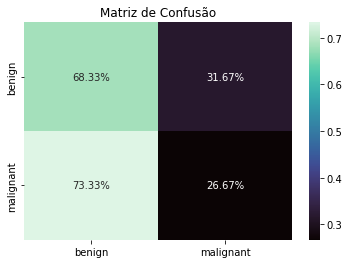

In [ ]:
matrix = confusion_matrix(validation_generator.labels, predictions_validation, normalize = 'true')
sns.heatmap(matrix, cmap = 'mako', annot = True, fmt = '.2%', xticklabels= validation_generator.class_indices.keys(), yticklabels = validation_generator.class_indices.keys())
plt.title('Matriz de Confusão')
plt.rcParams['figure.figsize'] = (24, 6)
plt.show()

In [ ]:
print(classification_report(validation_generator.labels, predictions_validation, target_names=validation_generator.class_indices.keys()))

              precision    recall  f1-score   support

      benign       0.79      0.68      0.73       120
   malignant       0.17      0.27      0.21        30

    accuracy                           0.60       150
   macro avg       0.48      0.47      0.47       150
weighted avg       0.67      0.60      0.63       150




4. **(2,0) Inicialmente, descarte a saída original e congele suas as camadas. Adicione uma nova camada de
saída com o número de classes adequadas para este problema. Compare com os resultados anteriores
e discuta os resultados.**

In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
tl_model = tf.keras.Sequential([
  resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

tl_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
tl_model_history = tl_model.fit(train_generator, epochs=10,callbacks=[early, roc],
                  validation_data=validation_generator, class_weight=dict(enumerate(class_weights)))

Epoch 1/10
63/63 [==============================] - 43s 612ms/step - loss: 0.7070 - accuracy: 0.5975 - val_loss: 0.4842 - val_accuracy: 0.7867
SHAPE (2000, 2)
roc-auc_train: 0.763 - roc-auc_val: 0.7583                                                                                                    
Epoch 2/10
63/63 [==============================] - 37s 579ms/step - loss: 0.5893 - accuracy: 0.6690 - val_loss: 0.4330 - val_accuracy: 0.8067
SHAPE (2000, 2)
roc-auc_train: 0.7939 - roc-auc_val: 0.7736                                                                                                    
Epoch 3/10
63/63 [==============================] - 37s 579ms/step - loss: 0.5863 - accuracy: 0.6900 - val_loss: 0.4635 - val_accuracy: 0.7600
SHAPE (2000, 2)
roc-auc_train: 0.8152 - roc-auc_val: 0.7792                                                                                                    
Epoch 4/10
63/63 [==============================] - 37s 592ms/step - loss: 0.5736 - accuracy

In [ ]:
tl_model.save('/content/weights_tlmodel.h5')
#tl_model.load_weights('weights_tlmodel.h5')

Da mesma forma que com a aplicação da SVM, o modelo abaixo performou melhor que o baseline em termos de F1, entretanto ele possui o mesmo problema da SVM. O recall da classe positiva é muito baixo, tornando o modelo inviável para aplicações reais mesmo que algumas métricas sejam maiores que o baseline.

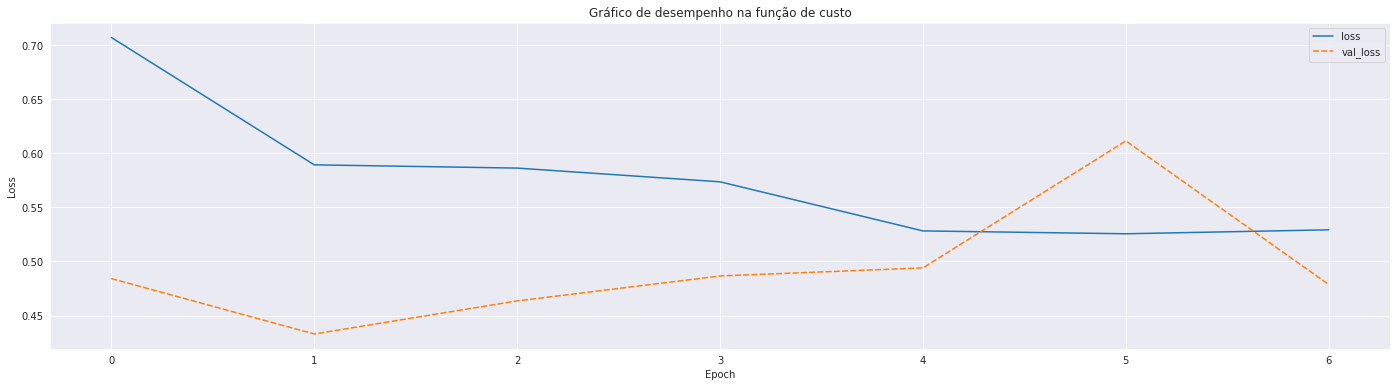

<Figure size 720x720 with 0 Axes>

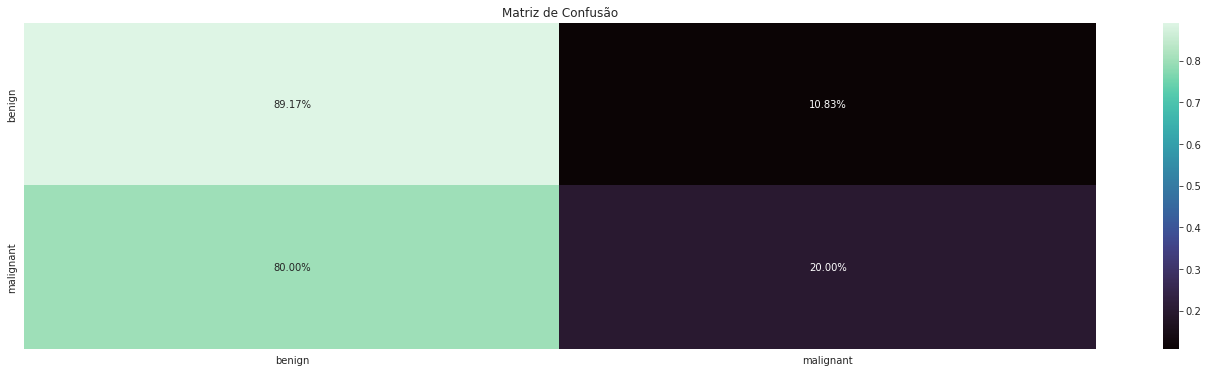

              precision    recall  f1-score   support

      benign       0.80      0.88      0.83       120
   malignant       0.17      0.10      0.12        30

    accuracy                           0.72       150
   macro avg       0.48      0.49      0.48       150
weighted avg       0.67      0.72      0.69       150



In [ ]:
plot_loss_evaluation(tl_model_history)
plot_confusion_matrix(tl_model, validation_generator.class_indices.keys(), validation_generator.labels, validation_generator)
print(classification_report(validation_generator.labels, np.argmax(tl_model.predict(validation_generator), axis=1), target_names=validation_generator.class_indices.keys()))


5. **(2,5) Descongele as camadas da rede extratora de features e realize o fine-tuning da rede, continuando
o treinamento. Compare com os resultados anteriores e discuta os resultados.**

In [ ]:
for layer in resnet.layers:
    layer.trainable = True
    
ft_model = tf.keras.Sequential([
  resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])    
    
ft_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ft_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
ft_model_history = ft_model.fit(train_generator, epochs=10,  batch_size=128, 
                  validation_data=validation_generator, class_weight=dict(enumerate(class_weights)))

Epoch 1/10
63/63 [==============================] - 57s 807ms/step - loss: 0.1749 - accuracy: 0.9250 - val_loss: 0.5425 - val_accuracy: 0.8600
Epoch 2/10
63/63 [==============================] - 50s 787ms/step - loss: 0.1411 - accuracy: 0.9385 - val_loss: 0.7164 - val_accuracy: 0.8467
Epoch 3/10
63/63 [==============================] - 51s 805ms/step - loss: 0.0889 - accuracy: 0.9680 - val_loss: 0.6751 - val_accuracy: 0.7867
Epoch 4/10
63/63 [==============================] - 49s 777ms/step - loss: 0.0892 - accuracy: 0.9660 - val_loss: 0.7483 - val_accuracy: 0.7933
Epoch 5/10
63/63 [==============================] - 50s 782ms/step - loss: 0.1200 - accuracy: 0.9500 - val_loss: 1.0160 - val_accuracy: 0.8267
Epoch 6/10
63/63 [==============================] - 49s 773ms/step - loss: 0.1083 - accuracy: 0.9555 - val_loss: 0.7194 - val_accuracy: 0.8133
Epoch 7/10
63/63 [==============================] - 49s 771ms/step - loss: 0.0891 - accuracy: 0.9655 - val_loss: 0.6462 - val_accuracy: 0.8400

In [ ]:
ft_model.save('/content/weights_ftmodel.h5')
#ft_model.load_weights('weights_ftmodel.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


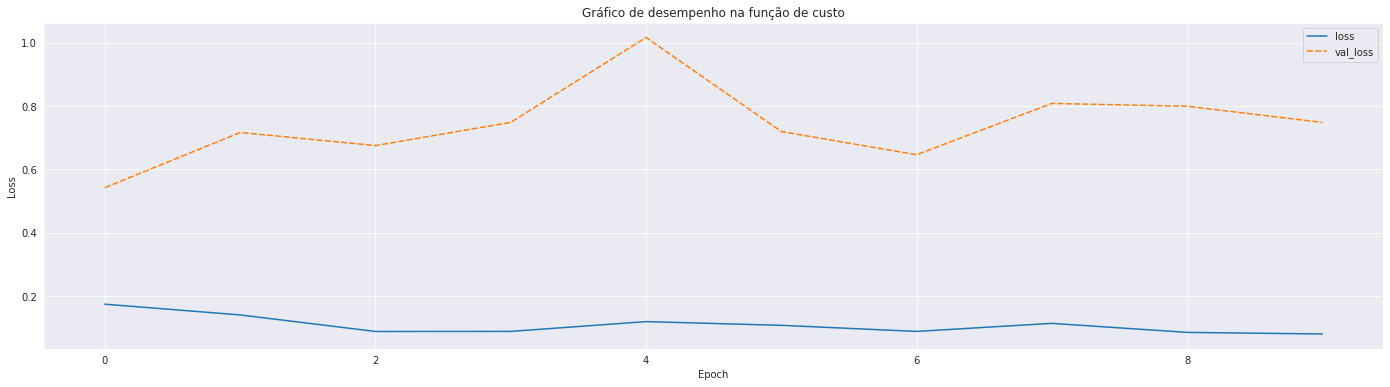

<Figure size 720x720 with 0 Axes>

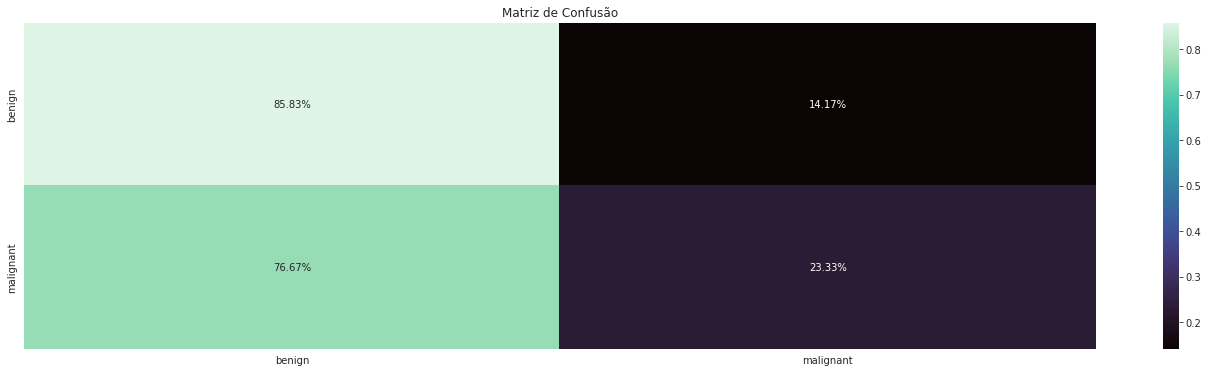

              precision    recall  f1-score   support

      benign       0.81      0.84      0.83       120
   malignant       0.27      0.23      0.25        30

    accuracy                           0.72       150
   macro avg       0.54      0.54      0.54       150
weighted avg       0.71      0.72      0.71       150



In [ ]:
plot_loss_evaluation(ft_model_history)
plot_confusion_matrix(ft_model, validation_generator.class_indices.keys(), validation_generator.labels, validation_generator)
print(classification_report(validation_generator.labels, np.argmax(ft_model.predict(validation_generator), axis=1), target_names=validation_generator.class_indices.keys()))


6. **(1,0) Avalie o melhor modelo no conjunto de teste. Compare com os resultados anteriores e discuta
os resultados. Quais foram as conclusões?**

Comparando todos os modelos, percebemos que a utilização da rede ResNet50 + SVM não trouxe resultados satisfatórios, assim como a utilização da ResNet50 Vanilla mudando a última camada e a ResNet com finetuning. Isso se deve ao fato de todas as redes terem um recall baixo para os casos malignos, o que é muito negativo para modelos médicos.

O modelo baseline acabou sendo o melhor, não pela sua precisão em cada classe, mas sim por ser capaz de não classificar muitos casos malignos como benignos. Assim vamos seguir com a sua estrutura, incluindo normalizações e algumas melhores práticas:

In [ ]:
from keras import regularizers
from keras.layers import BatchNormalization

In [ ]:
best_model = Sequential()
best_model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=input_shape, activation='relu', kernel_regularizer = regularizers.l2(0.001) , kernel_initializer = 'glorot_uniform'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(BatchNormalization())
best_model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=input_shape, activation='relu', kernel_regularizer = regularizers.l2(0.001) , kernel_initializer = 'glorot_uniform'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(BatchNormalization())
best_model.add(Flatten())
best_model.add(Dense(128, activation='relu', kernel_initializer = 'glorot_uniform'))
best_model.add(Dropout(0.2))
best_model.add(Dense(2, activation='softmax'))

best_model.summary()

best_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 110, 110, 64)      256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 106, 106, 64)      102464    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 53, 53, 64)        256       
_________________________________________________________________
flatten_9 (Flatten)          (None, 179776)          

In [ ]:
best_model_history = best_model.fit(train_generator, epochs=10,  batch_size=128, 
                  validation_data=validation_generator, class_weight=dict(enumerate(class_weights)))

Epoch 1/10
63/63 [==============================] - 38s 550ms/step - loss: 26.7261 - accuracy: 0.5285 - val_loss: 117.7934 - val_accuracy: 0.4133
Epoch 2/10
63/63 [==============================] - 34s 535ms/step - loss: 9.5272 - accuracy: 0.4660 - val_loss: 17.8836 - val_accuracy: 0.5933
Epoch 3/10
63/63 [==============================] - 34s 535ms/step - loss: 11.2464 - accuracy: 0.4620 - val_loss: 17.0071 - val_accuracy: 0.4867
Epoch 4/10
63/63 [==============================] - 34s 537ms/step - loss: 6.2117 - accuracy: 0.4050 - val_loss: 8.2319 - val_accuracy: 0.3467
Epoch 5/10
63/63 [==============================] - 34s 534ms/step - loss: 5.4324 - accuracy: 0.4165 - val_loss: 15.0569 - val_accuracy: 0.6533
Epoch 6/10
63/63 [==============================] - 34s 534ms/step - loss: 3.4350 - accuracy: 0.4090 - val_loss: 11.6893 - val_accuracy: 0.5533
Epoch 7/10
63/63 [==============================] - 36s 563ms/step - loss: 2.4186 - accuracy: 0.3600 - val_loss: 6.7611 - val_accuracy

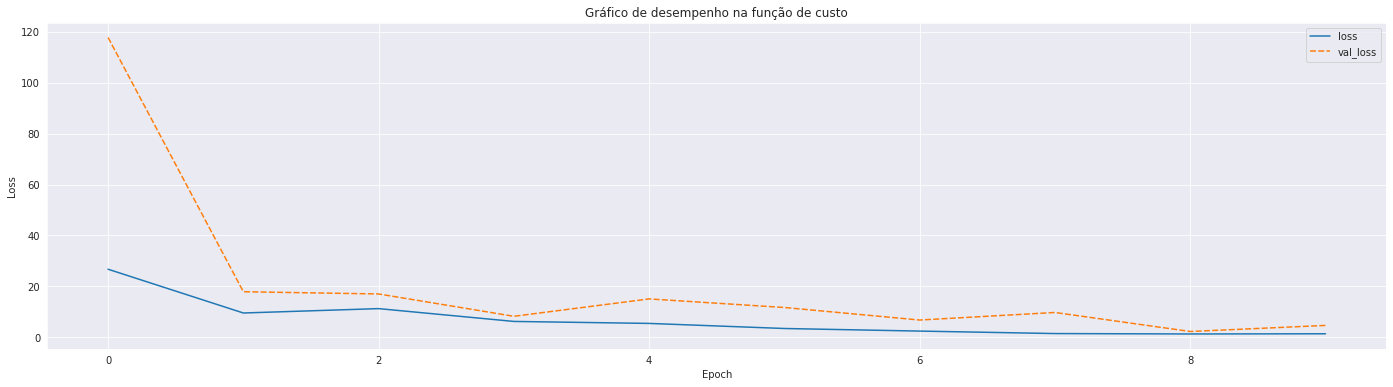

<Figure size 720x720 with 0 Axes>

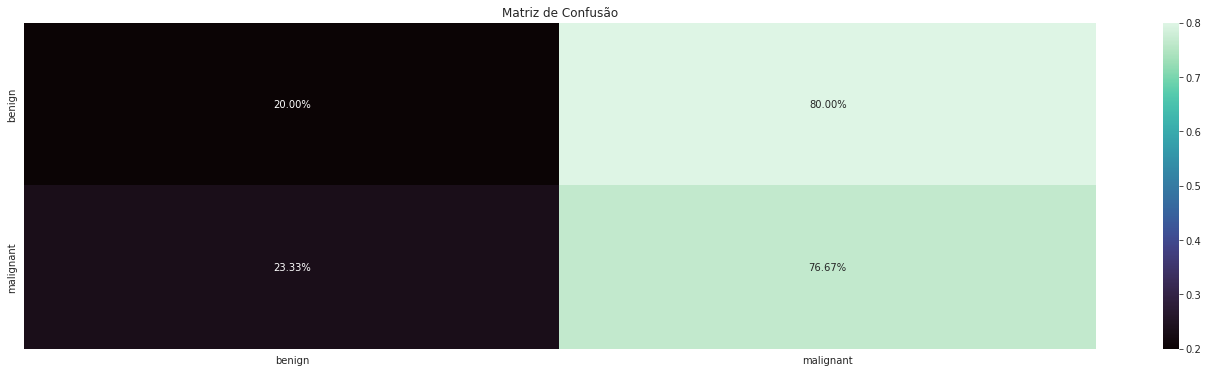

              precision    recall  f1-score   support

      benign       0.85      0.28      0.42       120
   malignant       0.22      0.80      0.34        30

    accuracy                           0.38       150
   macro avg       0.53      0.54      0.38       150
weighted avg       0.72      0.38      0.40       150



In [ ]:
plot_loss_evaluation(best_model_history)
plot_confusion_matrix(best_model, validation_generator.class_indices.keys(), validation_generator.labels, validation_generator)
print(classification_report(validation_generator.labels, np.argmax(best_model.predict(validation_generator), axis=1), target_names=validation_generator.class_indices.keys()))

Avaliando o baseline com algumas modificações no teste:

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator = test_datagen.flow_from_directory(
        'isic2017-test/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed = 42)

Found 600 images belonging to 2 classes.


Avaliando o desempenho no teste notamos o comportamento semelhante ao visto durante ao treinamento. A inclusão de pesos maiores na função de custo para a classe minoritária enviesou muito a performance, onde o foco do modelo foi em não errar a classe positiva, assim com um recall muito alto.

Esse comportamento de recall alto para classe positiva é esperado em modelos médicos, entretanto o baseline proposto praticamente classifica todas as amostras como maligna. 

Esse desempenho talvez possa ser melhorado com mais data augmentation, mais épocas e a exploração de novas arquiteturas.

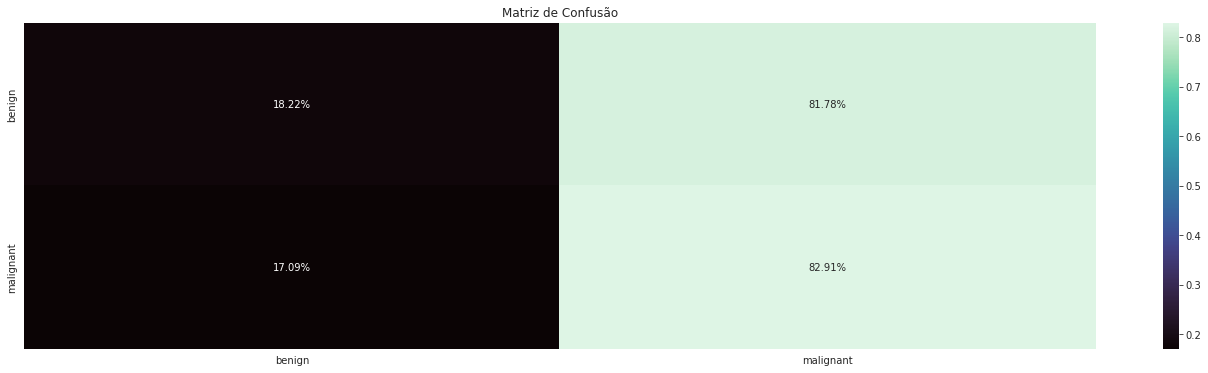

              precision    recall  f1-score   support

      benign       0.75      0.17      0.27       483
   malignant       0.18      0.77      0.30       117

    accuracy                           0.28       600
   macro avg       0.47      0.47      0.28       600
weighted avg       0.64      0.28      0.28       600



In [ ]:
plot_confusion_matrix(best_model, test_generator.class_indices.keys(), test_generator.labels, test_generator)
print(classification_report(test_generator.labels, np.argmax(best_model.predict(test_generator), axis=1), target_names=test_generator.class_indices.keys()))